In [1]:
"""
Reproduce the data behind Figure 2a of              
Thiemann, Igel, Wintenberger & Seldin
"A Strongly Quasiconvex PAC-Bayesian Bound" (arXiv:1608.05610v2).

The script follows *exactly* the construction in Sections 5 and 6 of the paper:

    • build an ensemble  H  of m weak RBF-SVMs
      - each is trained on      r = d+1   examples
      - validated on the other  nr       examples
    • compute the validation-loss vector   L̂_val(h,S)         (Eq. (13))
    • minimise the PAC-Bayes-lambda bound of Theorem 6 by the
      alternating (rho,lambda) procedure derived from Eqs. (7) and (8)
      - numerically-stable computation in log-domain
        (see the *hint* in Exercise 3.8 of the course notes)
    • evaluate on a disjoint test set and draw the figure that
      matches Figure 2(a)
"""

'\nReproduce the data behind Figure 2a of              \nThiemann, Igel, Wintenberger & Seldin\n"A Strongly Quasiconvex PAC-Bayesian Bound" (arXiv:1608.05610v2).\n\nThe script follows *exactly* the construction in Sections 5 and 6 of the paper:\n\n    • build an ensemble  H  of m weak RBF-SVMs\n      - each is trained on      r = d+1   examples\n      - validated on the other  nr       examples\n    • compute the validation-loss vector   L̂_val(h,S)         (Eq. (13))\n    • minimise the PAC-Bayes-lambda bound of Theorem 6 by the\n      alternating (rho,lambda) procedure derived from Eqs. (7) and (8)\n      - numerically-stable computation in log-domain\n        (see the *hint* in Exercise 3.8 of the course notes)\n    • evaluate on a disjoint test set and draw the figure that\n      matches Figure 2(a)\n'

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.special import logsumexp
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## 0.   Helper functions and initializations

In [3]:
rng = np.random.RandomState(42)
tol = 1e-12

In [4]:
def Jaakola_heuristic(X, y):
    """
    Compute the Jaakkola heuristic for the RBF kernel gamma parameter.

    The heuristic is based on the median distance between pairs of
    points with opposite labels. Specifically, gamma = 1 / (2 * sigma^2),
    where sigma is the median Euclidean distance between points from1
    different classes.

    Args:
        X (np.ndarray): Input data, shape (n_samples, n_features).
        y (np.ndarray): Class labels, shape (n_samples,).
                        Assumes binary classification with labels -1 and 1.

    Returns:
        float: The calculated gamma value.
    """

    # Separate data by class labels
    X0 = X[y == -1]
    X1 = X[y == 1]

    # Compute pairwise distances between points in X0 and X1
    # cdist(X0, X1) returns a matrix where G_ij is the distance between X0_i and X1_j
    G_matrix = cdist(X0, X1, metric="euclidean")

    # G will contain all the distances between opposite-label pairs
    # We take the median of these distances
    sigma = np.median(G_matrix)

    # If sigma is very close to zero (e.g., all points in one class are identical to points in another)
    # this could lead to a very large gamma. The 'tol' helps prevent division by zero.
    gamma = 1.0 / (2.0 * sigma**2 + tol)
    return gamma

## 1. Load and standardise Ionosphere data (as in paper’s experiments §6)

In [5]:
url = (
    "https://archive.ics.uci.edu/ml/"
    "machine-learning-databases/ionosphere/ionosphere.data"
)
df = pd.read_csv(url, header=None)
X = df.iloc[:, :-1].astype(float).values
y = np.where(df.iloc[:, -1].values == "g", 1, -1)  # 'g'->+1 , 'b'->−1

# split into Train S (200) / Test T (rest) as in the paper (Table 1)
X_S, X_T, y_S, y_T = train_test_split(X, y, train_size=200, stratify=y, random_state=0)

scaler = StandardScaler().fit(X_S)
X_S, X_T = scaler.transform(X_S), scaler.transform(X_T)
n, d = X_S.shape
r = d + 1  # Sec. 6: weak-learner train size
n_r = n - r  # size of each validation set
delta = 0.05  # confidence level used throughout paper

## 2. Baseline: single RBF-SVM tuned by 5-fold CV (as in §6)

In [6]:
# as specified on page 10
C_grid = [10.0**k for k in range(-3, 4)]
# as specified on page 10
gamma = Jaakola_heuristic(X_S, y_S)
gamma_grid = [gamma * 10.0**k for k in [-4, -2, 0, 2, 4]]

cv_svc = SVC(kernel="rbf")
param_grid = {"C": C_grid, "gamma": gamma_grid}
fold = KFold(n_splits=5, shuffle=False)
# 5-fold cross-validation
cv = GridSearchCV(cv_svc, param_grid, cv=fold, n_jobs=-1)
t0 = time.time()
cv.fit(X_S, y_S)
t_cv = time.time() - t0

print(" Results from Grid Search ")
print("\n The best estimator across ALL searched params:\n", cv.best_estimator_)
print("\n The best score across ALL searched params:\n", cv.best_score_)
print("\n The best parameters across ALL searched params:\n", cv.best_params_)

svm_cv = cv.best_estimator_
loss_cv = zero_one_loss(svm_cv.predict(X_T), y_T)
print("\n CV-SVM test loss:", loss_cv, " time:", t_cv, "s")


 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=10.0, gamma=np.float64(0.007064803820060141))

 The best score across ALL searched params:
 0.9450000000000001

 The best parameters across ALL searched params:
 {'C': 10.0, 'gamma': np.float64(0.007064803820060141)}

 CV-SVM test loss: 0.08609271523178808  time: 1.5922930240631104 s


## 3.   PAC-Bayes alternating-minimiation —— the core of Exercise 3.8

Implements Eq. (7) & (8) with bound Eq. (13)

In [7]:
def minimize_bound(L_val):
    """
    # Perform alternating minimisation of F(rho,lambda)$
    # (RHS of Eq. (13)).
    * L_val : vector (m,) of validation losses

    Returns rho, lambda^*, bound value.
    """
    m = len(L_val)
    log_pi = -np.log(m) * np.ones(m)  # uniform prior  \pi(h)=1/m (from page 10)
    lambda_ = 1.0

    for i in range(50):
        # Eq. (7): computed in log-domain for numerical stability
        log_rho = log_pi - lambda_ * n_r * L_val
        log_rho -= logsumexp(log_rho)
        rho = np.exp(log_rho)

        # helpers for Eq. (8) & bound. KL divergence is computed
        # in log-domain using the first equality in Eq. (9)
        KL = np.sum(rho * (log_rho - log_pi))
        L_emp = np.dot(rho, L_val)

        # Eq. (8): lambda_new
        num = 2.0
        denom = (
            np.sqrt(2.0 * n_r * L_emp / (KL + np.log(2 * np.sqrt(n_r) / delta)))
            + 1.0
            + 1.0
        )
        lambda_new = num / denom

        if abs(lambda_new - lambda_) < 1e-5:  # conv. criterion
            lambda_ = lambda_new
            break
        lambda_ = lambda_new

    # Eq. (13): value of PAC-Bayes-\lambda bound
    bound = L_emp / (1 - lambda_ / 2.0) + (KL + np.log(2 * np.sqrt(n_r) / delta)) / (
        n_r * lambda_ * (1 - lambda_ / 2.0)
    )

    return rho, lambda_, bound

## 4. Iterate over m = 10^0, ..., 10^2, ..  (Figure 2(a) x-axis)

In [8]:
# The m values are eye-catchers from figure 2(a) of the paper.
# They are not the same as in the paper, but they are close enough
# to the ones used in the paper to reproduce the figure.

M_list = [
    1,
    2,
    3,
    4,
    5,
    6,
    8,
    10,
    12,
    15,
    20,
    25,
    35,
    45,
    65,
    85,
    110,
    135,
    160,
    200,
]

# Number of runs for confidence interval computation
num_runs = 10


In [9]:
mv_loss_runs = np.zeros((num_runs, len(M_list)))
bound_val_runs = np.zeros((num_runs, len(M_list)))
run_time_runs = np.zeros((num_runs, len(M_list)))

# Pre-compute indices for more efficient masking
all_indices = np.arange(n)

print(f"Running {num_runs} experiments for confidence interval computation...")

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Use different random seed for each run
    run_rng = np.random.RandomState(42 + run)

    for m_idx, m in enumerate(M_list):
        t0 = time.time()
        L_val = np.zeros(m)
        predsT = np.zeros((m, len(y_T)))

        # Build ensemble of m weak SVMs  (Sec. 5 construction
        # of Hypothesis Space H)
        for i in range(m):
            # Select r = d + 1 random indices for training
            # and the rest for validation
            train_idx = run_rng.choice(n, r, replace=False)
            val_idx = np.setdiff1d(all_indices, train_idx, assume_unique=True)

            X_tr, y_tr = X_S[train_idx], y_S[train_idx]
            X_val, y_val = X_S[val_idx], y_S[val_idx]

            # Select random gamma from grid - p. 10 in paper
            gamma = run_rng.choice(gamma_grid)
            clf = SVC(kernel="rbf", C=1.0, gamma=gamma).fit(X_tr, y_tr)

            L_val[i] = zero_one_loss(clf.predict(X_val), y_val)
            predsT[i] = clf.predict(X_T)

        rho, _, bound = minimize_bound(L_val)

        # rho-weighted Majority vote of Eq. (3.31)
        # in Machine Learning: The science of selection under uncertainty
        mv_raw = rho @ predsT
        mv_pred = np.sign(mv_raw)  # ±1  (np.sign(0) returns 0 – no tie here)

        mv_loss_runs[run, m_idx] = zero_one_loss(mv_pred, y_T)
        bound_val_runs[run, m_idx] = bound  # randomized  classifier
        run_time_runs[run, m_idx] = time.time() - t0

# Compute statistics across runs
mv_loss_avg = np.mean(mv_loss_runs, axis=0)
mv_loss_std = np.std(mv_loss_runs, axis=0)
bound_val_avg = np.mean(bound_val_runs, axis=0)
bound_val_std = np.std(bound_val_runs, axis=0)
run_time_avg = np.mean(run_time_runs, axis=0)
run_time_std = np.std(run_time_runs, axis=0)

# Compute 95% confidence intervals
confidence_multiplier = 1.96  # For 95% confidence interval

# Method confidence intervals
mv_loss_conf = confidence_multiplier * mv_loss_std / np.sqrt(num_runs)
mv_loss_lower_conf = np.clip(mv_loss_avg - mv_loss_conf, 0.0, 1.0)
mv_loss_upper_conf = np.clip(mv_loss_avg + mv_loss_conf, 0.0, 1.0)

# Bound confidence intervals
bound_conf = confidence_multiplier * bound_val_std / np.sqrt(num_runs)
bound_lower_conf = np.clip(bound_val_avg - bound_conf, 0.0, 1.0)
bound_upper_conf = np.clip(bound_val_avg + bound_conf, 0.0, 1.0)

# Runtime confidence intervals
runtime_conf = confidence_multiplier * run_time_std / np.sqrt(num_runs)
runtime_lower_conf = np.clip(run_time_avg - runtime_conf, 0.0, np.inf)
runtime_upper_conf = run_time_avg + runtime_conf

print(f"\nCompleted {num_runs} runs for confidence interval computation.")


Running 10 experiments for confidence interval computation...
Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10

Completed 10 runs for confidence interval computation.


## 5. Plot Figure 2(a)

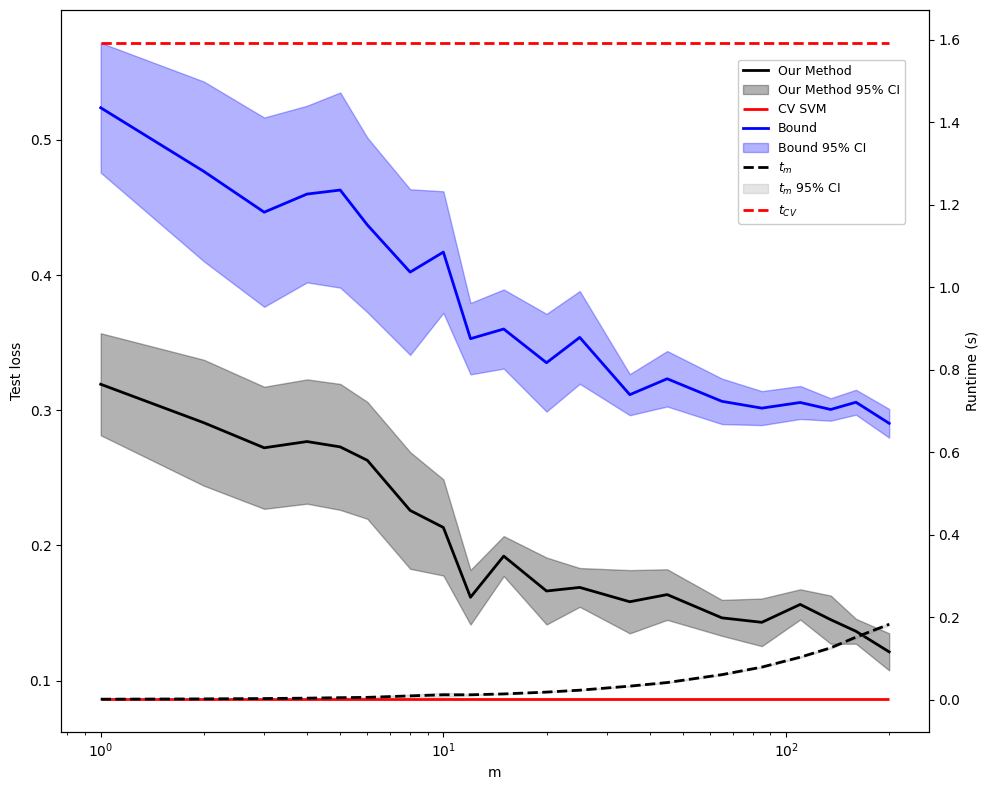


Statistics over 10 runs:
Method loss: 0.1212 ± 0.0137
Bound value: 0.2903 ± 0.0106
CV SVM loss: 0.0861 (deterministic)


In [10]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.set_xscale("log", base=10)
ax1.set_xlabel("m")
ax1.set_ylabel("Test loss")

# Plot method with confidence interval
ax1.plot(M_list, mv_loss_avg, "k-", label="Our Method", linewidth=2)
ax1.fill_between(
    M_list,
    mv_loss_lower_conf,
    mv_loss_upper_conf,
    alpha=0.3,
    color="black",
    label="Our Method 95% CI",
)

# CV SVM baseline (no confidence interval as it's deterministic)
ax1.hlines(
    loss_cv,
    M_list[0],
    M_list[-1],
    colors="r",
    linestyle="-",
    label="CV SVM",
    linewidth=2,
)

# Plot bound with confidence interval
ax1.plot(M_list, bound_val_avg, "b-", label="Bound", linewidth=2)
ax1.fill_between(
    M_list,
    bound_lower_conf,
    bound_upper_conf,
    alpha=0.3,
    color="blue",
    label="Bound 95% CI",
)

# Runtime on secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Runtime (s)")
ax2.plot(M_list, run_time_avg, "k--", label=r"$t_{m}$", linewidth=2)
ax2.fill_between(
    M_list,
    runtime_lower_conf,
    runtime_upper_conf,
    alpha=0.2,
    color="gray",
    label=r"$t_{m}$ 95% CI",
)
ax2.hlines(
    t_cv,
    M_list[0],
    M_list[-1],
    colors="r",
    linestyle="--",
    label=r"$t_{CV}$",
    linewidth=2,
)

# Merge legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines + lines2,
    labels + labels2,
    fontsize=9,
    framealpha=1.0,
    loc="upper right",
    bbox_to_anchor=(0.98, 0.94),
)

# Add title with confidence information
# ax1.set_title(
#     f"Figure 2(a) with 95% Confidence Intervals ({num_runs} runs)", fontsize=12, pad=20
# )

plt.tight_layout()
plt.savefig("figure_2a_conf_v2.pdf", bbox_inches="tight", dpi=600)
plt.show()

# Print some statistics
print(f"\nStatistics over {num_runs} runs:")
print(f"Method loss: {mv_loss_avg[-1]:.4f} ± {mv_loss_conf[-1]:.4f}")
print(f"Bound value: {bound_val_avg[-1]:.4f} ± {bound_conf[-1]:.4f}")
print(f"CV SVM loss: {loss_cv:.4f} (deterministic)")